# Laboratório de Processamento de Sinais para Comunicações
##  Prárica 05 - Cancelamento de Ruído

### Aluno - Matrícula:

Ezequias Márcio Silva de Santana Júnior - 371887

In [1]:
import numpy as np
import matplotlib.pylab as plt
import IPython.display as ipd
from scipy.io import wavfile
from scipy import signal
from scipy.linalg import norm

### O sinal

---------Informações---------
Audio: 'googlevoice.wav'
Taxa de amostragem: 48000 Hz
Amostras: (146304, 1)
Duração: 3.048 s



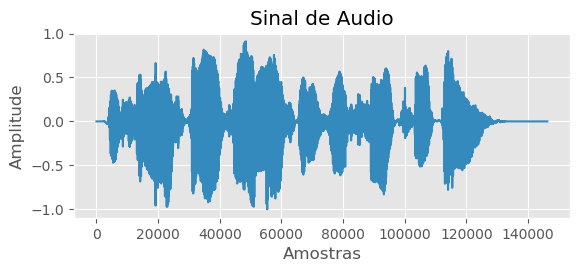

In [2]:
# Carregando audio:
rate, audio = wavfile.read('googlevoice.wav')
# Utilizando apenas um canal (mono) e normalizando as amostras:
audio = audio[:, [1]]/max(abs(audio[:, [1]]))

print(f'''---------Informações---------
Audio: 'googlevoice.wav'
Taxa de amostragem: {rate} Hz
Amostras: {audio.shape}
Duração: {audio.size/rate} s
''')
# Visualização:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Sinal de Audio')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(audio, 'C1')
    plt.show()

# Reprodução:
# wavfile.write('.wav', rate, audio)
ipd.Audio(data=audio.T, rate=rate)

### O ruído

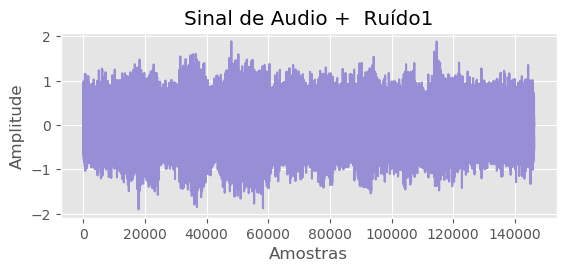

In [3]:
# Construindo ruído:
var = 1e-3 * norm(audio)
noise = np.random.normal(loc=0, scale=np.sqrt(var), size=audio.shape)

# Modelo para o cancelamento:
# Sistema 1:
c1 = 0.5
h1 = signal.dlti([1], [1, -c1])
h1 = signal.dimpulse(h1)   # Resposta ao impulso do Sistema DLTI
h1 = h1[1][0].flatten()       
# Ruído p/ sinal:
noise1 = signal.convolve(noise.flatten(), h1, mode='same')  # Convolução
noise1 = noise1[:, np.newaxis]

# Adição do ruído ao sinal de áudio:
sinal = audio + noise1

# Visualização:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Sinal de Audio +  Ruído1')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(sinal, 'C2')
    plt.show()

# Reprodução:
ipd.Audio(data=sinal.T, rate=rate)

### Definição do filtro adaptativo

In [4]:
# Definição do filtro, LMS:
def least_mean_squares(u, d, step, M):
    
    N = u.size - M + 1      # Número de Iterações
    y = np.zeros((N, 1))    # Saída do filtro
    e = np.zeros((N, 1))    # Erro
    mt_W = np.zeros((M, N)) # Matriz armazenando pesos
    # Algorítimo LMS:
    for n in range(N):
        x = np.flipud(u[n:n + M])[:, np.newaxis]
        y[n] = mt_W[:, [n-1]].T @ x
        e[n] = d[n + M - 1] - y[n]
        # Atualização:
        mt_W[:, [n]] = mt_W[:,[n-1]] + step * x * e[n]
        y[n] = mt_W[:, [n]].T @ x

    return y, e, mt_W


Valor real - Estimativa do filtro:
[[ 1.00e+00  1.00e+00]
 [ 0.00e+00 -1.58e-12]
 [ 0.00e+00  1.11e-12]
 [ 0.00e+00  1.32e-12]
 [ 0.00e+00  7.88e-13]
 [ 9.00e+00  9.00e+00]
 [ 0.00e+00  1.62e-12]
 [ 0.00e+00  8.67e-13]
 [ 0.00e+00 -1.55e-12]
 [ 1.00e-01  1.00e-01]]
Valores próx: True


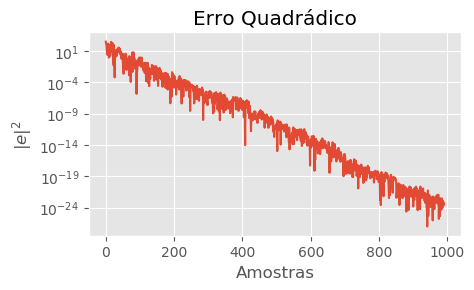

In [5]:
# Exemplo teste:
np.random.seed(0)
coef = np.r_[1, 4*[0], 9, 3*[0], 0.1]
u = np.random.randn(1000)
d = np.convolve(u, coef)

M = 10  # M-taps
step = 0.03
y, e, w = least_mean_squares(u, d, step, M)

np.set_printoptions(2)
print(f'''
Valor real - Estimativa do filtro:
{np.matrix([coef, w[:,-1]]).T}
Valores próx: {np.allclose(w[:,-1], coef)}''')

with plt.style.context('ggplot', True):
    plt.figure(figsize=[0.75*6.4, 0.55*0.75*6.4])
    plt.title('Erro Quadrádico')
    plt.ylabel('$|e|^2$')
    plt.xlabel('Amostras')
    plt.semilogy(np.abs(e)**2)
    plt.show()

### Procedimento de cancelamento
### Caso 1

$H_2(z)=1$ e $H_1(z)$ tem $c_1$ definida com um valor próximo de 0 para atender as condições para a aplicação do filtro.

In [6]:
# Modelo para o cancelamento:
# Sistema 1:
c1 = 0.05
h1 = signal.dlti([1], [1, -c1])
h1 = signal.dimpulse(h1)   # Resposta ao impulso do Sistema DLTI
h1 = h1[1][0].flatten()       
# Ruído p/ sinal:
noise1 = signal.convolve(noise.flatten(), h1, mode='same')  # Convolução
noise1 = noise1[:, np.newaxis]

# Adição do ruído ao sinal de áudio:
sinal1 = audio + noise1

# Sistema 2 entrada do filtro adaptativo: 
h2 = signal.dlti([1], [1])  # H2 = 1
h2 = signal.dimpulse(h2)   # Resposta ao impulso do Sistema DLTI
h2 = h2[1][0].flatten()       
# Ruído p/ o filtro:
noise2 = signal.convolve(noise.flatten(), h2, mode='same')  # Convolução
noise2 = noise2[:, np.newaxis]

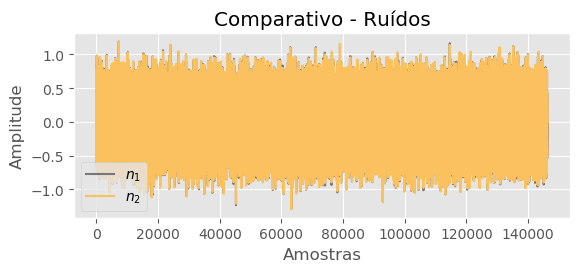

In [7]:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Comparativo - Ruídos')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(noise1, 'C3', label='$n_1$')
    plt.plot(noise2, 'C4', label='$n_2$')
    plt.legend()
    
#     plt.figure(figsize=[0.75*6.4, 0.55*0.75*6.4])
#     plt.title('Comparativo - Ruídos')
#     plt.ylabel('Amplitude')
#     plt.xlabel('Amostras')
#     plt.plot(noise, 'C3', label='$n_0$')
#     plt.plot(noise2, 'C4', label='$n_2$')
#     plt.legend()

In [8]:
# Parâmetros:
u1 = noise2.flatten()      # Sinal de entrada do filtro
d = sinal1     # Sinal desejado
M = 100        # Ordem do filtro
step = 0.195/norm(noise2)  # Passo (normalizado)

# Filtragem:
y1, e1, w1 = least_mean_squares(u1, d, step, M)

In [9]:
print(f'Coeficientes do filtro:\n{w1[:,-1]}')

Coeficientes do filtro:
[ 1.16e-04  1.00e+00  5.01e-02  2.65e-03  2.73e-04  1.45e-04  1.27e-04
  1.11e-04  9.12e-05  7.33e-05  5.00e-05  2.68e-05 -3.03e-07 -2.44e-05
 -6.05e-05 -9.15e-05 -1.10e-04 -1.26e-04 -1.36e-04 -1.42e-04 -1.51e-04
 -1.51e-04 -1.52e-04 -1.62e-04 -1.53e-04 -1.44e-04 -1.38e-04 -1.33e-04
 -1.16e-04 -1.03e-04 -9.30e-05 -7.94e-05 -5.35e-05 -3.12e-05 -1.01e-05
  1.36e-05  2.85e-05  5.25e-05  6.87e-05  7.00e-05  7.17e-05  6.63e-05
  6.78e-05  6.57e-05  6.91e-05  6.01e-05  6.53e-05  7.41e-05  8.85e-05
  9.14e-05  9.81e-05  1.01e-04  1.13e-04  1.27e-04  1.37e-04  1.33e-04
  1.36e-04  1.34e-04  1.27e-04  1.22e-04  1.16e-04  1.06e-04  1.06e-04
  1.21e-04  1.35e-04  1.63e-04  1.82e-04  2.06e-04  2.38e-04  2.55e-04
  2.66e-04  2.79e-04  2.99e-04  3.10e-04  3.29e-04  3.48e-04  3.67e-04
  3.72e-04  3.81e-04  3.89e-04  3.97e-04  3.97e-04  3.91e-04  3.80e-04
  3.68e-04  3.50e-04  3.21e-04  3.10e-04  2.85e-04  2.67e-04  2.43e-04
  2.14e-04  1.82e-04  1.47e-04  1.02e-04  6.15e-05  1

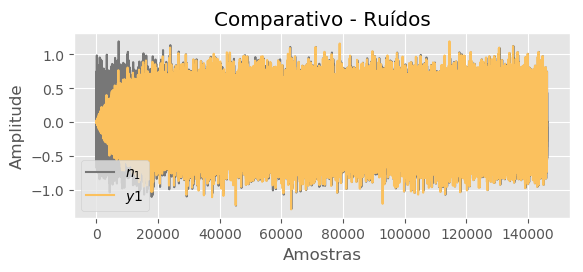

In [10]:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Comparativo - Ruídos')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(noise1, 'C3', label='$n_1$')
    plt.plot(y1, 'C4', label='$y1$')
    
    plt.legend()

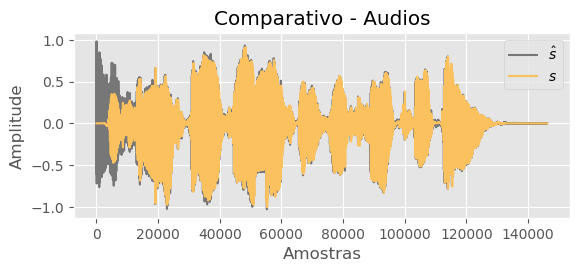

In [11]:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Comparativo - Audios')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(e1, 'C3', label='$\hat{s}$')
    plt.plot(audio, 'C4', label='$s$')
    plt.legend()

In [12]:
# Reprodução:
ipd.Audio(data=e1.T, rate=rate)

### Procedimento de cancelamento
### Caso 2

$H_1(z)$ e $H_2(z)$ possuem FT semelhantes e atendem as condições do cancelamento 
com as constantes $c_1$ e $c_2$.

In [20]:
# Modelo para o cancelamento:
# Sistema 1:
c1 = 0.09
h1 = signal.dlti([1], [1, -c1])
h1 = signal.dimpulse(h1)   # Resposta ao impulso do Sistema DLTI
h1 = h1[1][0].flatten()       
# Ruído p/ sinal:
noise1 = signal.convolve(noise.flatten(), h1, mode='same')  # Convolução
noise1 = noise1[:, np.newaxis]

# Adição do ruído ao sinal de áudio:
sinal2 = audio + noise1

# Sistema 2 entrada do filtro adaptativo:
c2 = 0.05
h2 = signal.dlti([1], [1, -c2])
h2 = signal.dimpulse(h2)   # Resposta ao impulso do Sistema DLTI
h2 = h2[1][0].flatten()       
# Ruído p/ o filtro:
noise2 = signal.convolve(noise.flatten(), h2, mode='same')  # Convolução
noise2 = noise2[:, np.newaxis]

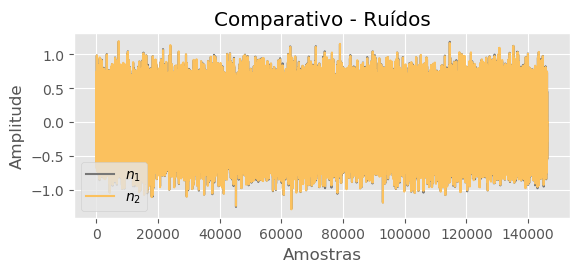

In [21]:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Comparativo - Ruídos')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(noise1, 'C3', label='$n_1$')
    plt.plot(noise2, 'C4', label='$n_2$')
    plt.legend()

In [22]:
# Parâmetros:
u2 = noise2.flatten()      # Sinal de entrada do filtro
d = sinal2     # Sinal desejado
M = 100        # Ordem do filtro
step = 0.195/norm(noise2)  # Passo (normalizado)

# Filtragem:
y2, e2, w2 = least_mean_squares(u2, d, step, M)

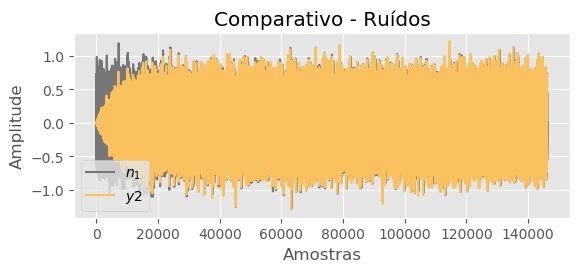

In [23]:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Comparativo - Ruídos')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(noise1, 'C3', label='$n_1$')
    plt.plot(y2, 'C4', label='$y2$')
    plt.legend()

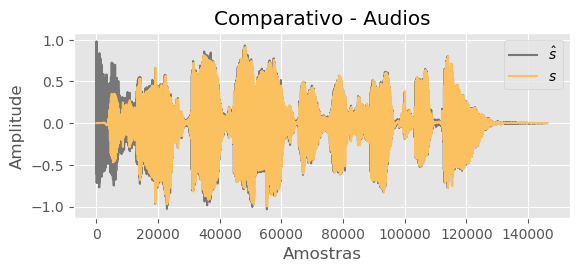

In [24]:
with plt.style.context('ggplot', True):
    plt.figure(figsize=[1*6.4, .5*0.75*6.4])
    plt.title('Comparativo - Audios')
    plt.ylabel('Amplitude')
    plt.xlabel('Amostras')
    plt.plot(e2, 'C3', label='$\hat{s}$')
    plt.plot(audio, 'C4', label='$s$')
    plt.legend()

In [25]:
# Reprodução:
ipd.Audio(data=e2.T, rate=rate)

In [26]:
whos

Variable             Type        Data/Info
------------------------------------------
M                    int         100
audio                ndarray     146304x1: 146304 elems, type `float64`, 1170432 bytes (1.1162109375 Mb)
c1                   float       0.09
c2                   float       0.05
coef                 ndarray     10: 10 elems, type `float64`, 80 bytes
d                    ndarray     146304x1: 146304 elems, type `float64`, 1170432 bytes (1.1162109375 Mb)
e                    ndarray     991x1: 991 elems, type `float64`, 7928 bytes
e1                   ndarray     146205x1: 146205 elems, type `float64`, 1169640 bytes (1.1154556274414062 Mb)
e2                   ndarray     146205x1: 146205 elems, type `float64`, 1169640 bytes (1.1154556274414062 Mb)
h1                   ndarray     100: 100 elems, type `float64`, 800 bytes
h2                   ndarray     100: 100 elems, type `float64`, 800 bytes
ipd                  module      <module 'IPython.display'<...>ages/I